In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 14 # the number of class
        self.feat_d = 105
        self.filters = 32
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/JHMDB/'
C = Config()

In [4]:
random.seed(123)

def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        p = normlize_range(p)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [62]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=15,joint_d=2,feat_d=91,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = block(x,filters)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.05)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = block(x_d_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = block(x_d_fast,filters) 
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)

    x = block(x,filters*8)
    
    return Model(inputs=[M,P],outputs=x)


def build_AR_single(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [63]:
AR_single = build_AR_single(C)
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_25 (Model)                (None, 4, 256)       445888      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_13 (Global (None, 256)          0           model_25[1][0]                   
__________

## Train and test on GT_split 1

In [64]:
Train = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 406.46it/s]


In [66]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=600,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/600
433/433 [==============================] - 20s 46ms/step - loss: 0.0574 - acc: 1.0000 - val_loss: 0.9520 - val_acc: 0.7670
Epoch 2/600
433/433 [==============================] - 0s 175us/step - loss: 0.0667 - acc: 0.9908 - val_loss: 0.9526 - val_acc: 0.7614
Epoch 3/600
433/433 [==============================] - 0s 174us/step - loss: 0.0572 - acc: 0.9954 - val_loss: 0.9532 - val_acc: 0.7614
Epoch 4/600
433/433 [==============================] - 0s 211us/step - loss: 0.0612 - acc: 0.9977 - val_loss: 0.9535 - val_acc: 0.7614
Epoch 5/600
433/433 [==============================] - 0s 207us/step - loss: 0.0734 - acc: 0.9908 - val_loss: 0.9534 - val_acc: 0.7557
Epoch 6/600
433/433 [==============================] - 0s 206us/step - loss: 0.0609 - acc: 0.9931 - val_loss: 0.9534 - val_acc: 0.7557
Epoch 7/600
433/433 [==============================] - 0s 207us/step - loss: 0.0667 - acc: 0.9977 - val_loss: 0.9536 - val_acc: 0.7557
Epoch 8/6

Epoch 61/600
433/433 [==============================] - 0s 228us/step - loss: 0.0443 - acc: 1.0000 - val_loss: 0.9500 - val_acc: 0.7557
Epoch 62/600
433/433 [==============================] - 0s 222us/step - loss: 0.0537 - acc: 1.0000 - val_loss: 0.9503 - val_acc: 0.7557
Epoch 63/600
433/433 [==============================] - 0s 226us/step - loss: 0.0550 - acc: 1.0000 - val_loss: 0.9505 - val_acc: 0.7557
Epoch 64/600
433/433 [==============================] - 0s 218us/step - loss: 0.0766 - acc: 0.9885 - val_loss: 0.9508 - val_acc: 0.7557
Epoch 65/600
433/433 [==============================] - 0s 197us/step - loss: 0.0527 - acc: 0.9954 - val_loss: 0.9510 - val_acc: 0.7557
Epoch 66/600
433/433 [==============================] - 0s 196us/step - loss: 0.0538 - acc: 0.9977 - val_loss: 0.9511 - val_acc: 0.7557
Epoch 67/600
433/433 [==============================] - 0s 228us/step - loss: 0.0807 - acc: 0.9908 - val_loss: 0.9511 - val_acc: 0.7557
Epoch 68/600
433/433 [==========================

433/433 [==============================] - 0s 213us/step - loss: 0.0473 - acc: 1.0000 - val_loss: 0.9545 - val_acc: 0.7614
Epoch 122/600
433/433 [==============================] - 0s 224us/step - loss: 0.0445 - acc: 0.9977 - val_loss: 0.9543 - val_acc: 0.7614
Epoch 123/600
433/433 [==============================] - 0s 201us/step - loss: 0.0750 - acc: 0.9931 - val_loss: 0.9544 - val_acc: 0.7614
Epoch 124/600
433/433 [==============================] - 0s 211us/step - loss: 0.0568 - acc: 0.9931 - val_loss: 0.9543 - val_acc: 0.7614
Epoch 125/600
433/433 [==============================] - 0s 219us/step - loss: 0.0497 - acc: 0.9977 - val_loss: 0.9543 - val_acc: 0.7614
Epoch 126/600
433/433 [==============================] - 0s 174us/step - loss: 0.0537 - acc: 0.9954 - val_loss: 0.9544 - val_acc: 0.7614
Epoch 127/600
433/433 [==============================] - 0s 205us/step - loss: 0.0488 - acc: 1.0000 - val_loss: 0.9543 - val_acc: 0.7614
Epoch 128/600
433/433 [==============================] 

Epoch 181/600
433/433 [==============================] - 0s 174us/step - loss: 0.0650 - acc: 0.9954 - val_loss: 0.9571 - val_acc: 0.7727
Epoch 182/600
433/433 [==============================] - 0s 191us/step - loss: 0.0542 - acc: 0.9954 - val_loss: 0.9574 - val_acc: 0.7727
Epoch 183/600
433/433 [==============================] - 0s 196us/step - loss: 0.0606 - acc: 0.9954 - val_loss: 0.9578 - val_acc: 0.7727
Epoch 184/600
433/433 [==============================] - 0s 204us/step - loss: 0.0561 - acc: 0.9977 - val_loss: 0.9581 - val_acc: 0.7727
Epoch 185/600
433/433 [==============================] - 0s 211us/step - loss: 0.0492 - acc: 0.9954 - val_loss: 0.9584 - val_acc: 0.7727
Epoch 186/600
433/433 [==============================] - 0s 208us/step - loss: 0.0579 - acc: 0.9931 - val_loss: 0.9587 - val_acc: 0.7727
Epoch 187/600
433/433 [==============================] - 0s 204us/step - loss: 0.0586 - acc: 0.9931 - val_loss: 0.9589 - val_acc: 0.7727
Epoch 188/600
433/433 [==================

Epoch 241/600
433/433 [==============================] - 0s 197us/step - loss: 0.0490 - acc: 1.0000 - val_loss: 0.9592 - val_acc: 0.7670
Epoch 242/600
433/433 [==============================] - 0s 215us/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.9592 - val_acc: 0.7670
Epoch 243/600
433/433 [==============================] - 0s 191us/step - loss: 0.0421 - acc: 1.0000 - val_loss: 0.9592 - val_acc: 0.7670
Epoch 244/600
433/433 [==============================] - 0s 221us/step - loss: 0.0483 - acc: 0.9977 - val_loss: 0.9591 - val_acc: 0.7670
Epoch 245/600
433/433 [==============================] - 0s 228us/step - loss: 0.0508 - acc: 1.0000 - val_loss: 0.9591 - val_acc: 0.7670
Epoch 246/600
433/433 [==============================] - 0s 213us/step - loss: 0.0574 - acc: 0.9977 - val_loss: 0.9591 - val_acc: 0.7670
Epoch 247/600
433/433 [==============================] - 0s 204us/step - loss: 0.0522 - acc: 0.9977 - val_loss: 0.9591 - val_acc: 0.7670
Epoch 248/600
433/433 [==================

Epoch 301/600
433/433 [==============================] - 0s 195us/step - loss: 0.0608 - acc: 0.9954 - val_loss: 0.9587 - val_acc: 0.7727
Epoch 302/600
433/433 [==============================] - 0s 197us/step - loss: 0.0496 - acc: 1.0000 - val_loss: 0.9588 - val_acc: 0.7727
Epoch 303/600
433/433 [==============================] - 0s 216us/step - loss: 0.0554 - acc: 0.9977 - val_loss: 0.9588 - val_acc: 0.7727
Epoch 304/600
433/433 [==============================] - 0s 228us/step - loss: 0.0623 - acc: 0.9954 - val_loss: 0.9589 - val_acc: 0.7727
Epoch 305/600
433/433 [==============================] - 0s 222us/step - loss: 0.0597 - acc: 0.9954 - val_loss: 0.9589 - val_acc: 0.7727
Epoch 306/600
433/433 [==============================] - 0s 208us/step - loss: 0.0547 - acc: 0.9954 - val_loss: 0.9590 - val_acc: 0.7727
Epoch 307/600
433/433 [==============================] - 0s 208us/step - loss: 0.0479 - acc: 1.0000 - val_loss: 0.9593 - val_acc: 0.7727
Epoch 308/600
433/433 [==================

Epoch 361/600
433/433 [==============================] - 0s 211us/step - loss: 0.0521 - acc: 1.0000 - val_loss: 0.9606 - val_acc: 0.7670
Epoch 362/600
433/433 [==============================] - 0s 199us/step - loss: 0.0567 - acc: 0.9977 - val_loss: 0.9606 - val_acc: 0.7670
Epoch 363/600
433/433 [==============================] - 0s 186us/step - loss: 0.0439 - acc: 1.0000 - val_loss: 0.9606 - val_acc: 0.7670
Epoch 364/600
433/433 [==============================] - 0s 204us/step - loss: 0.0519 - acc: 0.9931 - val_loss: 0.9607 - val_acc: 0.7670
Epoch 365/600
433/433 [==============================] - 0s 202us/step - loss: 0.0447 - acc: 0.9954 - val_loss: 0.9608 - val_acc: 0.7670
Epoch 366/600
433/433 [==============================] - 0s 203us/step - loss: 0.0569 - acc: 0.9954 - val_loss: 0.9609 - val_acc: 0.7670
Epoch 367/600
433/433 [==============================] - 0s 211us/step - loss: 0.0519 - acc: 0.9954 - val_loss: 0.9610 - val_acc: 0.7670
Epoch 368/600
433/433 [==================

Epoch 421/600
433/433 [==============================] - 0s 191us/step - loss: 0.0616 - acc: 0.9931 - val_loss: 0.9682 - val_acc: 0.7614
Epoch 422/600
433/433 [==============================] - 0s 218us/step - loss: 0.0505 - acc: 0.9977 - val_loss: 0.9682 - val_acc: 0.7614
Epoch 423/600
433/433 [==============================] - 0s 212us/step - loss: 0.0425 - acc: 0.9977 - val_loss: 0.9685 - val_acc: 0.7614
Epoch 424/600
433/433 [==============================] - 0s 189us/step - loss: 0.0507 - acc: 1.0000 - val_loss: 0.9688 - val_acc: 0.7614
Epoch 425/600
433/433 [==============================] - 0s 216us/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.9691 - val_acc: 0.7614
Epoch 426/600
433/433 [==============================] - 0s 184us/step - loss: 0.0574 - acc: 0.9931 - val_loss: 0.9692 - val_acc: 0.7614
Epoch 427/600
433/433 [==============================] - 0s 191us/step - loss: 0.0423 - acc: 1.0000 - val_loss: 0.9695 - val_acc: 0.7614
Epoch 428/600
433/433 [==================

Epoch 481/600
433/433 [==============================] - 0s 211us/step - loss: 0.0702 - acc: 0.9908 - val_loss: 0.9645 - val_acc: 0.7614
Epoch 482/600
433/433 [==============================] - 0s 205us/step - loss: 0.0649 - acc: 0.9931 - val_loss: 0.9643 - val_acc: 0.7614
Epoch 483/600
433/433 [==============================] - 0s 223us/step - loss: 0.0451 - acc: 1.0000 - val_loss: 0.9642 - val_acc: 0.7614
Epoch 484/600
433/433 [==============================] - 0s 205us/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.9641 - val_acc: 0.7670
Epoch 485/600
433/433 [==============================] - 0s 210us/step - loss: 0.0493 - acc: 0.9931 - val_loss: 0.9642 - val_acc: 0.7670
Epoch 486/600
433/433 [==============================] - 0s 231us/step - loss: 0.0574 - acc: 0.9908 - val_loss: 0.9641 - val_acc: 0.7670
Epoch 487/600
433/433 [==============================] - 0s 230us/step - loss: 0.0577 - acc: 0.9908 - val_loss: 0.9640 - val_acc: 0.7670
Epoch 488/600
433/433 [==================

Epoch 541/600
433/433 [==============================] - 0s 215us/step - loss: 0.0454 - acc: 1.0000 - val_loss: 0.9673 - val_acc: 0.7841
Epoch 542/600
433/433 [==============================] - 0s 225us/step - loss: 0.0511 - acc: 1.0000 - val_loss: 0.9673 - val_acc: 0.7841
Epoch 543/600
433/433 [==============================] - 0s 210us/step - loss: 0.0466 - acc: 1.0000 - val_loss: 0.9673 - val_acc: 0.7784
Epoch 544/600
433/433 [==============================] - 0s 205us/step - loss: 0.0554 - acc: 0.9977 - val_loss: 0.9675 - val_acc: 0.7784
Epoch 545/600
433/433 [==============================] - 0s 214us/step - loss: 0.0489 - acc: 0.9977 - val_loss: 0.9674 - val_acc: 0.7784
Epoch 546/600
433/433 [==============================] - 0s 207us/step - loss: 0.0513 - acc: 0.9977 - val_loss: 0.9675 - val_acc: 0.7784
Epoch 547/600
433/433 [==============================] - 0s 212us/step - loss: 0.0644 - acc: 0.9908 - val_loss: 0.9674 - val_acc: 0.7784
Epoch 548/600
433/433 [==================

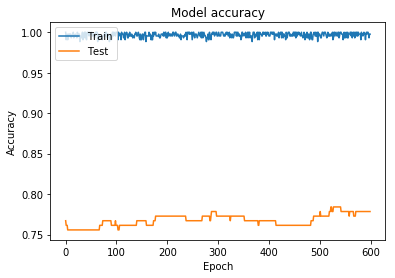

In [67]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 2

In [68]:
Train = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 273.61it/s]


In [69]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [73]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=600,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/600
433/433 [==============================] - 22s 51ms/step - loss: 0.0551 - acc: 0.9954 - val_loss: 1.0628 - val_acc: 0.7273
Epoch 2/600
433/433 [==============================] - 0s 228us/step - loss: 0.0840 - acc: 0.9838 - val_loss: 0.8871 - val_acc: 0.7557
Epoch 3/600
433/433 [==============================] - 0s 209us/step - loss: 0.0920 - acc: 0.9885 - val_loss: 0.8807 - val_acc: 0.7500
Epoch 4/600
433/433 [==============================] - 0s 199us/step - loss: 0.0858 - acc: 0.9815 - val_loss: 1.0296 - val_acc: 0.7045
Epoch 5/600
433/433 [==============================] - 0s 202us/step - loss: 0.0902 - acc: 0.9861 - val_loss: 1.1569 - val_acc: 0.6818
Epoch 6/600
433/433 [==============================] - 0s 206us/step - loss: 0.0943 - acc: 0.9861 - val_loss: 1.2906 - val_acc: 0.6591
Epoch 7/600
433/433 [==============================] - 0s 247us/step - loss: 0.0498 - acc: 0.9977 - val_loss: 1.3559 - val_acc: 0.6420
Epoch 8/6

Epoch 61/600
433/433 [==============================] - 0s 203us/step - loss: 0.0183 - acc: 1.0000 - val_loss: 1.0600 - val_acc: 0.7330
Epoch 62/600
433/433 [==============================] - 0s 205us/step - loss: 0.0257 - acc: 0.9954 - val_loss: 1.0605 - val_acc: 0.7330
Epoch 63/600
433/433 [==============================] - 0s 214us/step - loss: 0.0275 - acc: 0.9954 - val_loss: 1.0602 - val_acc: 0.7330
Epoch 64/600
433/433 [==============================] - 0s 220us/step - loss: 0.0226 - acc: 0.9977 - val_loss: 1.0594 - val_acc: 0.7330
Epoch 65/600
433/433 [==============================] - 0s 210us/step - loss: 0.0184 - acc: 0.9977 - val_loss: 1.0568 - val_acc: 0.7330
Epoch 66/600
433/433 [==============================] - 0s 205us/step - loss: 0.0274 - acc: 0.9954 - val_loss: 1.0557 - val_acc: 0.7330
Epoch 67/600
433/433 [==============================] - 0s 233us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 1.0531 - val_acc: 0.7330
Epoch 68/600
433/433 [==========================

433/433 [==============================] - 0s 217us/step - loss: 0.0281 - acc: 0.9977 - val_loss: 1.0033 - val_acc: 0.7614
Epoch 122/600
433/433 [==============================] - 0s 210us/step - loss: 0.0245 - acc: 0.9954 - val_loss: 1.0029 - val_acc: 0.7614
Epoch 123/600
433/433 [==============================] - 0s 222us/step - loss: 0.0256 - acc: 0.9954 - val_loss: 1.0022 - val_acc: 0.7614
Epoch 124/600
433/433 [==============================] - 0s 216us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 1.0017 - val_acc: 0.7614
Epoch 125/600
433/433 [==============================] - 0s 212us/step - loss: 0.0208 - acc: 0.9977 - val_loss: 1.0015 - val_acc: 0.7614
Epoch 126/600
433/433 [==============================] - 0s 221us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 1.0010 - val_acc: 0.7614
Epoch 127/600
433/433 [==============================] - 0s 205us/step - loss: 0.0188 - acc: 0.9977 - val_loss: 1.0007 - val_acc: 0.7614
Epoch 128/600
433/433 [==============================] 

Epoch 181/600
433/433 [==============================] - 0s 215us/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.9970 - val_acc: 0.7557
Epoch 182/600
433/433 [==============================] - 0s 214us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.9968 - val_acc: 0.7557
Epoch 183/600
433/433 [==============================] - 0s 212us/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.9966 - val_acc: 0.7557
Epoch 184/600
433/433 [==============================] - 0s 239us/step - loss: 0.0194 - acc: 0.9977 - val_loss: 0.9966 - val_acc: 0.7557
Epoch 185/600
433/433 [==============================] - 0s 233us/step - loss: 0.0218 - acc: 0.9977 - val_loss: 0.9967 - val_acc: 0.7557
Epoch 186/600
433/433 [==============================] - 0s 208us/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.9966 - val_acc: 0.7557
Epoch 187/600
433/433 [==============================] - 0s 199us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.9965 - val_acc: 0.7557
Epoch 188/600
433/433 [==================

Epoch 241/600
433/433 [==============================] - 0s 248us/step - loss: 0.0187 - acc: 0.9977 - val_loss: 1.0009 - val_acc: 0.7557
Epoch 242/600
433/433 [==============================] - 0s 189us/step - loss: 0.0210 - acc: 0.9954 - val_loss: 1.0011 - val_acc: 0.7557
Epoch 243/600
433/433 [==============================] - 0s 214us/step - loss: 0.0180 - acc: 1.0000 - val_loss: 1.0011 - val_acc: 0.7557
Epoch 244/600
433/433 [==============================] - 0s 206us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 1.0013 - val_acc: 0.7557
Epoch 245/600
433/433 [==============================] - 0s 209us/step - loss: 0.0208 - acc: 0.9977 - val_loss: 1.0012 - val_acc: 0.7557
Epoch 246/600
433/433 [==============================] - 0s 205us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 1.0011 - val_acc: 0.7557
Epoch 247/600
433/433 [==============================] - 0s 213us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 1.0012 - val_acc: 0.7557
Epoch 248/600
433/433 [==================

Epoch 301/600
433/433 [==============================] - 0s 233us/step - loss: 0.0173 - acc: 0.9977 - val_loss: 1.0078 - val_acc: 0.7500
Epoch 302/600
433/433 [==============================] - 0s 225us/step - loss: 0.0162 - acc: 0.9977 - val_loss: 1.0078 - val_acc: 0.7500
Epoch 303/600
433/433 [==============================] - 0s 211us/step - loss: 0.0186 - acc: 1.0000 - val_loss: 1.0079 - val_acc: 0.7500
Epoch 304/600
433/433 [==============================] - 0s 235us/step - loss: 0.0177 - acc: 0.9977 - val_loss: 1.0080 - val_acc: 0.7500
Epoch 305/600
433/433 [==============================] - 0s 208us/step - loss: 0.0260 - acc: 0.9954 - val_loss: 1.0079 - val_acc: 0.7500
Epoch 306/600
433/433 [==============================] - 0s 216us/step - loss: 0.0215 - acc: 1.0000 - val_loss: 1.0079 - val_acc: 0.7500
Epoch 307/600
433/433 [==============================] - 0s 211us/step - loss: 0.0224 - acc: 1.0000 - val_loss: 1.0080 - val_acc: 0.7500
Epoch 308/600
433/433 [==================

Epoch 361/600
433/433 [==============================] - 0s 223us/step - loss: 0.0195 - acc: 0.9954 - val_loss: 1.0100 - val_acc: 0.7443
Epoch 362/600
433/433 [==============================] - 0s 234us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 1.0098 - val_acc: 0.7443
Epoch 363/600
433/433 [==============================] - 0s 202us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 1.0097 - val_acc: 0.7443
Epoch 364/600
433/433 [==============================] - 0s 215us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 1.0096 - val_acc: 0.7443
Epoch 365/600
433/433 [==============================] - 0s 221us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.0094 - val_acc: 0.7443
Epoch 366/600
433/433 [==============================] - 0s 186us/step - loss: 0.0173 - acc: 1.0000 - val_loss: 1.0094 - val_acc: 0.7443
Epoch 367/600
433/433 [==============================] - 0s 199us/step - loss: 0.0208 - acc: 0.9977 - val_loss: 1.0093 - val_acc: 0.7443
Epoch 368/600
433/433 [==================

Epoch 421/600
433/433 [==============================] - 0s 205us/step - loss: 0.0191 - acc: 1.0000 - val_loss: 1.0144 - val_acc: 0.7443
Epoch 422/600
433/433 [==============================] - 0s 227us/step - loss: 0.0165 - acc: 1.0000 - val_loss: 1.0143 - val_acc: 0.7443
Epoch 423/600
433/433 [==============================] - 0s 213us/step - loss: 0.0254 - acc: 0.9931 - val_loss: 1.0141 - val_acc: 0.7443
Epoch 424/600
433/433 [==============================] - 0s 216us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 1.0140 - val_acc: 0.7443
Epoch 425/600
433/433 [==============================] - 0s 217us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.0140 - val_acc: 0.7443
Epoch 426/600
433/433 [==============================] - 0s 214us/step - loss: 0.0254 - acc: 1.0000 - val_loss: 1.0137 - val_acc: 0.7443
Epoch 427/600
433/433 [==============================] - 0s 224us/step - loss: 0.0170 - acc: 0.9977 - val_loss: 1.0137 - val_acc: 0.7443
Epoch 428/600
433/433 [==================

Epoch 481/600
433/433 [==============================] - 0s 200us/step - loss: 0.0207 - acc: 1.0000 - val_loss: 1.0175 - val_acc: 0.7386
Epoch 482/600
433/433 [==============================] - 0s 225us/step - loss: 0.0187 - acc: 1.0000 - val_loss: 1.0178 - val_acc: 0.7386
Epoch 483/600
433/433 [==============================] - 0s 216us/step - loss: 0.0169 - acc: 1.0000 - val_loss: 1.0177 - val_acc: 0.7386
Epoch 484/600
433/433 [==============================] - 0s 228us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 1.0178 - val_acc: 0.7386
Epoch 485/600
433/433 [==============================] - 0s 227us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 1.0180 - val_acc: 0.7386
Epoch 486/600
433/433 [==============================] - 0s 197us/step - loss: 0.0165 - acc: 1.0000 - val_loss: 1.0181 - val_acc: 0.7386
Epoch 487/600
433/433 [==============================] - 0s 189us/step - loss: 0.0133 - acc: 1.0000 - val_loss: 1.0184 - val_acc: 0.7386
Epoch 488/600
433/433 [==================

Epoch 541/600
433/433 [==============================] - 0s 213us/step - loss: 0.0163 - acc: 0.9977 - val_loss: 1.0188 - val_acc: 0.7557
Epoch 542/600
433/433 [==============================] - 0s 217us/step - loss: 0.0164 - acc: 1.0000 - val_loss: 1.0186 - val_acc: 0.7557
Epoch 543/600
433/433 [==============================] - 0s 201us/step - loss: 0.0194 - acc: 0.9977 - val_loss: 1.0186 - val_acc: 0.7557
Epoch 544/600
433/433 [==============================] - 0s 223us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 1.0185 - val_acc: 0.7557
Epoch 545/600
433/433 [==============================] - 0s 211us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 1.0187 - val_acc: 0.7557
Epoch 546/600
433/433 [==============================] - 0s 228us/step - loss: 0.0228 - acc: 1.0000 - val_loss: 1.0188 - val_acc: 0.7557
Epoch 547/600
433/433 [==============================] - 0s 214us/step - loss: 0.0143 - acc: 1.0000 - val_loss: 1.0190 - val_acc: 0.7557
Epoch 548/600
433/433 [==================

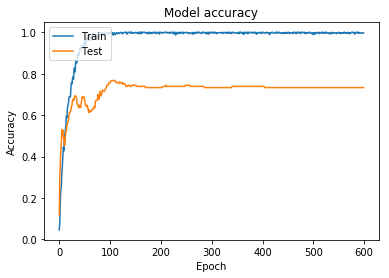

In [71]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [74]:
Train = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 175/175 [00:00<00:00, 349.56it/s]


In [75]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [76]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=1000,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 434 samples, validate on 175 samples
Epoch 1/1000
434/434 [==============================] - 24s 55ms/step - loss: 3.2939 - acc: 0.0415 - val_loss: 2.5789 - val_acc: 0.1829
Epoch 2/1000
434/434 [==============================] - 0s 244us/step - loss: 2.8728 - acc: 0.1083 - val_loss: 2.4706 - val_acc: 0.2800
Epoch 3/1000
434/434 [==============================] - 0s 240us/step - loss: 2.5664 - acc: 0.1728 - val_loss: 2.4546 - val_acc: 0.3086
Epoch 4/1000
434/434 [==============================] - 0s 208us/step - loss: 2.3041 - acc: 0.2788 - val_loss: 2.4233 - val_acc: 0.3314
Epoch 5/1000
434/434 [==============================] - 0s 208us/step - loss: 2.3055 - acc: 0.2788 - val_loss: 2.3641 - val_acc: 0.3486
Epoch 6/1000
434/434 [==============================] - 0s 206us/step - loss: 2.0987 - acc: 0.3433 - val_loss: 2.3276 - val_acc: 0.3429
Epoch 7/1000
434/434 [==============================] - 0s 187us/step - loss: 1.9570 - acc: 0.3710 - val_loss: 2.2788 - val_acc: 0.3714
Ep

Epoch 61/1000
434/434 [==============================] - 0s 256us/step - loss: 0.1642 - acc: 0.9862 - val_loss: 1.1699 - val_acc: 0.7200
Epoch 62/1000
434/434 [==============================] - 0s 233us/step - loss: 0.1404 - acc: 0.9954 - val_loss: 1.1698 - val_acc: 0.7143
Epoch 63/1000
434/434 [==============================] - 0s 228us/step - loss: 0.1334 - acc: 0.9862 - val_loss: 1.1692 - val_acc: 0.7200
Epoch 64/1000
434/434 [==============================] - 0s 194us/step - loss: 0.1296 - acc: 0.9908 - val_loss: 1.1670 - val_acc: 0.7143
Epoch 65/1000
434/434 [==============================] - 0s 225us/step - loss: 0.1366 - acc: 0.9862 - val_loss: 1.1674 - val_acc: 0.7143
Epoch 66/1000
434/434 [==============================] - 0s 240us/step - loss: 0.1435 - acc: 0.9816 - val_loss: 1.1686 - val_acc: 0.7200
Epoch 67/1000
434/434 [==============================] - 0s 243us/step - loss: 0.1463 - acc: 0.9885 - val_loss: 1.1628 - val_acc: 0.7200
Epoch 68/1000
434/434 [==================

Epoch 121/1000
434/434 [==============================] - 0s 206us/step - loss: 0.0678 - acc: 0.9977 - val_loss: 1.0787 - val_acc: 0.7429
Epoch 122/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0661 - acc: 1.0000 - val_loss: 1.0756 - val_acc: 0.7429
Epoch 123/1000
434/434 [==============================] - 0s 210us/step - loss: 0.0577 - acc: 0.9977 - val_loss: 1.0721 - val_acc: 0.7429
Epoch 124/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0523 - acc: 1.0000 - val_loss: 1.0690 - val_acc: 0.7429
Epoch 125/1000
434/434 [==============================] - 0s 211us/step - loss: 0.0702 - acc: 0.9885 - val_loss: 1.0662 - val_acc: 0.7429
Epoch 126/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0664 - acc: 1.0000 - val_loss: 1.0632 - val_acc: 0.7371
Epoch 127/1000
434/434 [==============================] - 0s 211us/step - loss: 0.0723 - acc: 0.9977 - val_loss: 1.0600 - val_acc: 0.7371
Epoch 128/1000
434/434 [==========

Epoch 181/1000
434/434 [==============================] - 0s 230us/step - loss: 0.0775 - acc: 0.9908 - val_loss: 0.9513 - val_acc: 0.7657
Epoch 182/1000
434/434 [==============================] - 0s 223us/step - loss: 0.0618 - acc: 0.9977 - val_loss: 0.9506 - val_acc: 0.7657
Epoch 183/1000
434/434 [==============================] - 0s 226us/step - loss: 0.0609 - acc: 0.9931 - val_loss: 0.9497 - val_acc: 0.7657
Epoch 184/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0621 - acc: 0.9977 - val_loss: 0.9489 - val_acc: 0.7657
Epoch 185/1000
434/434 [==============================] - 0s 207us/step - loss: 0.0715 - acc: 0.9885 - val_loss: 0.9481 - val_acc: 0.7657
Epoch 186/1000
434/434 [==============================] - 0s 191us/step - loss: 0.0491 - acc: 1.0000 - val_loss: 0.9472 - val_acc: 0.7657
Epoch 187/1000
434/434 [==============================] - 0s 227us/step - loss: 0.0569 - acc: 0.9977 - val_loss: 0.9465 - val_acc: 0.7657
Epoch 188/1000
434/434 [==========

Epoch 241/1000
434/434 [==============================] - 0s 211us/step - loss: 0.0609 - acc: 0.9977 - val_loss: 0.9245 - val_acc: 0.7600
Epoch 242/1000
434/434 [==============================] - 0s 204us/step - loss: 0.0744 - acc: 0.9908 - val_loss: 0.9242 - val_acc: 0.7600
Epoch 243/1000
434/434 [==============================] - 0s 207us/step - loss: 0.0646 - acc: 0.9954 - val_loss: 0.9238 - val_acc: 0.7600
Epoch 244/1000
434/434 [==============================] - 0s 224us/step - loss: 0.0663 - acc: 0.9977 - val_loss: 0.9235 - val_acc: 0.7657
Epoch 245/1000
434/434 [==============================] - 0s 248us/step - loss: 0.0534 - acc: 0.9977 - val_loss: 0.9231 - val_acc: 0.7657
Epoch 246/1000
434/434 [==============================] - 0s 232us/step - loss: 0.0705 - acc: 0.9954 - val_loss: 0.9229 - val_acc: 0.7657
Epoch 247/1000
434/434 [==============================] - 0s 228us/step - loss: 0.0643 - acc: 0.9908 - val_loss: 0.9226 - val_acc: 0.7657
Epoch 248/1000
434/434 [==========

Epoch 301/1000
434/434 [==============================] - 0s 205us/step - loss: 0.0659 - acc: 0.9977 - val_loss: 0.9139 - val_acc: 0.7657
Epoch 302/1000
434/434 [==============================] - 0s 221us/step - loss: 0.0754 - acc: 0.9931 - val_loss: 0.9138 - val_acc: 0.7657
Epoch 303/1000
434/434 [==============================] - 0s 208us/step - loss: 0.0610 - acc: 0.9977 - val_loss: 0.9136 - val_acc: 0.7657
Epoch 304/1000
434/434 [==============================] - 0s 192us/step - loss: 0.0748 - acc: 0.9908 - val_loss: 0.9134 - val_acc: 0.7657
Epoch 305/1000
434/434 [==============================] - 0s 226us/step - loss: 0.0556 - acc: 0.9977 - val_loss: 0.9133 - val_acc: 0.7600
Epoch 306/1000
434/434 [==============================] - 0s 193us/step - loss: 0.0643 - acc: 0.9954 - val_loss: 0.9131 - val_acc: 0.7600
Epoch 307/1000
434/434 [==============================] - 0s 215us/step - loss: 0.0537 - acc: 1.0000 - val_loss: 0.9129 - val_acc: 0.7600
Epoch 308/1000
434/434 [==========

Epoch 361/1000
434/434 [==============================] - 0s 214us/step - loss: 0.0562 - acc: 1.0000 - val_loss: 0.9071 - val_acc: 0.7657
Epoch 362/1000
434/434 [==============================] - 0s 226us/step - loss: 0.0739 - acc: 0.9908 - val_loss: 0.9072 - val_acc: 0.7657
Epoch 363/1000
434/434 [==============================] - 0s 251us/step - loss: 0.0551 - acc: 1.0000 - val_loss: 0.9071 - val_acc: 0.7657
Epoch 364/1000
434/434 [==============================] - 0s 255us/step - loss: 0.0520 - acc: 1.0000 - val_loss: 0.9070 - val_acc: 0.7657
Epoch 365/1000
434/434 [==============================] - 0s 218us/step - loss: 0.0641 - acc: 0.9954 - val_loss: 0.9068 - val_acc: 0.7657
Epoch 366/1000
434/434 [==============================] - 0s 235us/step - loss: 0.0580 - acc: 0.9977 - val_loss: 0.9067 - val_acc: 0.7657
Epoch 367/1000
434/434 [==============================] - 0s 217us/step - loss: 0.0574 - acc: 0.9954 - val_loss: 0.9066 - val_acc: 0.7657
Epoch 368/1000
434/434 [==========

Epoch 421/1000
434/434 [==============================] - 0s 206us/step - loss: 0.0628 - acc: 0.9954 - val_loss: 0.9039 - val_acc: 0.7657
Epoch 422/1000
434/434 [==============================] - 0s 225us/step - loss: 0.0505 - acc: 0.9954 - val_loss: 0.9040 - val_acc: 0.7657
Epoch 423/1000
434/434 [==============================] - 0s 222us/step - loss: 0.0687 - acc: 0.9954 - val_loss: 0.9043 - val_acc: 0.7657
Epoch 424/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0533 - acc: 1.0000 - val_loss: 0.9042 - val_acc: 0.7657
Epoch 425/1000
434/434 [==============================] - 0s 218us/step - loss: 0.0682 - acc: 0.9931 - val_loss: 0.9043 - val_acc: 0.7657
Epoch 426/1000
434/434 [==============================] - 0s 227us/step - loss: 0.0638 - acc: 0.9954 - val_loss: 0.9043 - val_acc: 0.7657
Epoch 427/1000
434/434 [==============================] - 0s 195us/step - loss: 0.0547 - acc: 0.9954 - val_loss: 0.9042 - val_acc: 0.7657
Epoch 428/1000
434/434 [==========

Epoch 481/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0596 - acc: 0.9954 - val_loss: 0.9043 - val_acc: 0.7600
Epoch 482/1000
434/434 [==============================] - 0s 199us/step - loss: 0.0529 - acc: 1.0000 - val_loss: 0.9044 - val_acc: 0.7600
Epoch 483/1000
434/434 [==============================] - 0s 229us/step - loss: 0.0609 - acc: 0.9977 - val_loss: 0.9045 - val_acc: 0.7600
Epoch 484/1000
434/434 [==============================] - 0s 236us/step - loss: 0.0583 - acc: 0.9931 - val_loss: 0.9046 - val_acc: 0.7600
Epoch 485/1000
434/434 [==============================] - 0s 225us/step - loss: 0.0588 - acc: 0.9954 - val_loss: 0.9047 - val_acc: 0.7600
Epoch 486/1000
434/434 [==============================] - 0s 232us/step - loss: 0.0630 - acc: 0.9954 - val_loss: 0.9048 - val_acc: 0.7600
Epoch 487/1000
434/434 [==============================] - 0s 213us/step - loss: 0.0595 - acc: 1.0000 - val_loss: 0.9048 - val_acc: 0.7600
Epoch 488/1000
434/434 [==========

Epoch 541/1000
434/434 [==============================] - 0s 224us/step - loss: 0.0633 - acc: 0.9977 - val_loss: 0.9017 - val_acc: 0.7600
Epoch 542/1000
434/434 [==============================] - 0s 211us/step - loss: 0.0594 - acc: 0.9954 - val_loss: 0.9015 - val_acc: 0.7600
Epoch 543/1000
434/434 [==============================] - 0s 226us/step - loss: 0.0617 - acc: 0.9931 - val_loss: 0.9015 - val_acc: 0.7600
Epoch 544/1000
434/434 [==============================] - 0s 226us/step - loss: 0.0569 - acc: 0.9977 - val_loss: 0.9015 - val_acc: 0.7600
Epoch 545/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0655 - acc: 0.9954 - val_loss: 0.9013 - val_acc: 0.7600
Epoch 546/1000
434/434 [==============================] - 0s 200us/step - loss: 0.0565 - acc: 0.9954 - val_loss: 0.9013 - val_acc: 0.7600
Epoch 547/1000
434/434 [==============================] - 0s 250us/step - loss: 0.0580 - acc: 0.9954 - val_loss: 0.9013 - val_acc: 0.7600
Epoch 548/1000
434/434 [==========

Epoch 601/1000
434/434 [==============================] - 0s 207us/step - loss: 0.0514 - acc: 0.9977 - val_loss: 0.9028 - val_acc: 0.7600
Epoch 602/1000
434/434 [==============================] - 0s 213us/step - loss: 0.0596 - acc: 0.9977 - val_loss: 0.9028 - val_acc: 0.7600
Epoch 603/1000
434/434 [==============================] - 0s 196us/step - loss: 0.0566 - acc: 0.9954 - val_loss: 0.9028 - val_acc: 0.7600
Epoch 604/1000
434/434 [==============================] - 0s 232us/step - loss: 0.0622 - acc: 0.9908 - val_loss: 0.9029 - val_acc: 0.7600
Epoch 605/1000
434/434 [==============================] - 0s 205us/step - loss: 0.0602 - acc: 0.9977 - val_loss: 0.9029 - val_acc: 0.7600
Epoch 606/1000
434/434 [==============================] - 0s 216us/step - loss: 0.0594 - acc: 0.9931 - val_loss: 0.9029 - val_acc: 0.7600
Epoch 607/1000
434/434 [==============================] - 0s 240us/step - loss: 0.0582 - acc: 0.9977 - val_loss: 0.9029 - val_acc: 0.7600
Epoch 608/1000
434/434 [==========

Epoch 661/1000
434/434 [==============================] - 0s 257us/step - loss: 0.0613 - acc: 0.9954 - val_loss: 0.9055 - val_acc: 0.7600
Epoch 662/1000
434/434 [==============================] - 0s 209us/step - loss: 0.0652 - acc: 0.9954 - val_loss: 0.9054 - val_acc: 0.7600
Epoch 663/1000
434/434 [==============================] - 0s 220us/step - loss: 0.0559 - acc: 0.9954 - val_loss: 0.9053 - val_acc: 0.7600
Epoch 664/1000
434/434 [==============================] - 0s 237us/step - loss: 0.0568 - acc: 0.9977 - val_loss: 0.9053 - val_acc: 0.7600
Epoch 665/1000
434/434 [==============================] - 0s 210us/step - loss: 0.0510 - acc: 0.9977 - val_loss: 0.9053 - val_acc: 0.7600
Epoch 666/1000
434/434 [==============================] - 0s 231us/step - loss: 0.0522 - acc: 0.9977 - val_loss: 0.9054 - val_acc: 0.7600
Epoch 667/1000
434/434 [==============================] - 0s 216us/step - loss: 0.0561 - acc: 0.9977 - val_loss: 0.9055 - val_acc: 0.7600
Epoch 668/1000
434/434 [==========

Epoch 721/1000
434/434 [==============================] - 0s 234us/step - loss: 0.0450 - acc: 0.9977 - val_loss: 0.9015 - val_acc: 0.7600
Epoch 722/1000
434/434 [==============================] - 0s 201us/step - loss: 0.0617 - acc: 0.9977 - val_loss: 0.9016 - val_acc: 0.7600
Epoch 723/1000
434/434 [==============================] - 0s 212us/step - loss: 0.0748 - acc: 0.9954 - val_loss: 0.9016 - val_acc: 0.7600
Epoch 724/1000
434/434 [==============================] - 0s 222us/step - loss: 0.0534 - acc: 0.9977 - val_loss: 0.9016 - val_acc: 0.7600
Epoch 725/1000
434/434 [==============================] - 0s 228us/step - loss: 0.0676 - acc: 0.9954 - val_loss: 0.9017 - val_acc: 0.7600
Epoch 726/1000
434/434 [==============================] - 0s 230us/step - loss: 0.0714 - acc: 0.9931 - val_loss: 0.9018 - val_acc: 0.7600
Epoch 727/1000
434/434 [==============================] - 0s 255us/step - loss: 0.0592 - acc: 0.9977 - val_loss: 0.9018 - val_acc: 0.7600
Epoch 728/1000
434/434 [==========

Epoch 781/1000
434/434 [==============================] - 0s 212us/step - loss: 0.0495 - acc: 1.0000 - val_loss: 0.9018 - val_acc: 0.7600
Epoch 782/1000
434/434 [==============================] - 0s 202us/step - loss: 0.0567 - acc: 0.9954 - val_loss: 0.9018 - val_acc: 0.7600
Epoch 783/1000
434/434 [==============================] - 0s 193us/step - loss: 0.0662 - acc: 0.9885 - val_loss: 0.9022 - val_acc: 0.7600
Epoch 784/1000
434/434 [==============================] - 0s 206us/step - loss: 0.0568 - acc: 0.9977 - val_loss: 0.9025 - val_acc: 0.7600
Epoch 785/1000
434/434 [==============================] - 0s 218us/step - loss: 0.0561 - acc: 0.9954 - val_loss: 0.9028 - val_acc: 0.7600
Epoch 786/1000
434/434 [==============================] - 0s 204us/step - loss: 0.0535 - acc: 0.9954 - val_loss: 0.9031 - val_acc: 0.7600
Epoch 787/1000
434/434 [==============================] - 0s 214us/step - loss: 0.0519 - acc: 0.9977 - val_loss: 0.9032 - val_acc: 0.7600
Epoch 788/1000
434/434 [==========

Epoch 841/1000
434/434 [==============================] - 0s 231us/step - loss: 0.0501 - acc: 0.9954 - val_loss: 0.9044 - val_acc: 0.7657
Epoch 842/1000
434/434 [==============================] - 0s 204us/step - loss: 0.0567 - acc: 1.0000 - val_loss: 0.9044 - val_acc: 0.7657
Epoch 843/1000
434/434 [==============================] - 0s 219us/step - loss: 0.0480 - acc: 1.0000 - val_loss: 0.9044 - val_acc: 0.7657
Epoch 844/1000
434/434 [==============================] - 0s 198us/step - loss: 0.0529 - acc: 0.9977 - val_loss: 0.9046 - val_acc: 0.7657
Epoch 845/1000
434/434 [==============================] - 0s 223us/step - loss: 0.0646 - acc: 0.9931 - val_loss: 0.9047 - val_acc: 0.7657
Epoch 846/1000
434/434 [==============================] - 0s 204us/step - loss: 0.0754 - acc: 0.9954 - val_loss: 0.9049 - val_acc: 0.7657
Epoch 847/1000
434/434 [==============================] - 0s 220us/step - loss: 0.0592 - acc: 0.9954 - val_loss: 0.9050 - val_acc: 0.7657
Epoch 848/1000
434/434 [==========

Epoch 901/1000
434/434 [==============================] - 0s 192us/step - loss: 0.0610 - acc: 0.9954 - val_loss: 0.9070 - val_acc: 0.7600
Epoch 902/1000
434/434 [==============================] - 0s 206us/step - loss: 0.0518 - acc: 0.9977 - val_loss: 0.9072 - val_acc: 0.7657
Epoch 903/1000
434/434 [==============================] - 0s 211us/step - loss: 0.0438 - acc: 0.9977 - val_loss: 0.9072 - val_acc: 0.7657
Epoch 904/1000
434/434 [==============================] - 0s 213us/step - loss: 0.0513 - acc: 1.0000 - val_loss: 0.9073 - val_acc: 0.7657
Epoch 905/1000
434/434 [==============================] - 0s 215us/step - loss: 0.0458 - acc: 0.9954 - val_loss: 0.9073 - val_acc: 0.7657
Epoch 906/1000
434/434 [==============================] - 0s 215us/step - loss: 0.0563 - acc: 0.9977 - val_loss: 0.9074 - val_acc: 0.7657
Epoch 907/1000
434/434 [==============================] - 0s 218us/step - loss: 0.0457 - acc: 0.9954 - val_loss: 0.9075 - val_acc: 0.7657
Epoch 908/1000
434/434 [==========

Epoch 961/1000
434/434 [==============================] - 0s 186us/step - loss: 0.0587 - acc: 0.9977 - val_loss: 0.9092 - val_acc: 0.7600
Epoch 962/1000
434/434 [==============================] - 0s 200us/step - loss: 0.0556 - acc: 0.9954 - val_loss: 0.9090 - val_acc: 0.7600
Epoch 963/1000
434/434 [==============================] - 0s 224us/step - loss: 0.0524 - acc: 1.0000 - val_loss: 0.9090 - val_acc: 0.7600
Epoch 964/1000
434/434 [==============================] - 0s 217us/step - loss: 0.0518 - acc: 0.9954 - val_loss: 0.9092 - val_acc: 0.7600
Epoch 965/1000
434/434 [==============================] - 0s 237us/step - loss: 0.0515 - acc: 1.0000 - val_loss: 0.9091 - val_acc: 0.7600
Epoch 966/1000
434/434 [==============================] - 0s 210us/step - loss: 0.0441 - acc: 1.0000 - val_loss: 0.9091 - val_acc: 0.7600
Epoch 967/1000
434/434 [==============================] - 0s 198us/step - loss: 0.0442 - acc: 0.9954 - val_loss: 0.9091 - val_acc: 0.7543
Epoch 968/1000
434/434 [==========

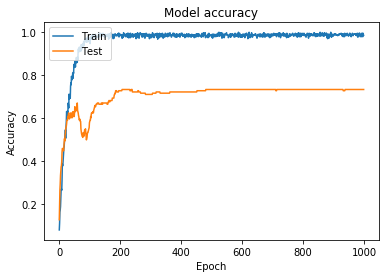

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculate average 

In [72]:
(0.78+0.76+0.76)/3

0.7466666666666667